In [14]:
#### - - - Loading libraries and Input - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

from utils.blast_utils import makeblast_db, blastn, default_blast_columns, alignment_absolute_start_end, total_coverage, unmapped_subject_regions
#from utils.block_utils import run_blast_mapping
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from pathlib import Path
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# TO DO:
# Then find the number of time each block map, te proportion of bases mapped by each block (two barplots, and two stacked plots) 

set_trim_nam = {
    'input_clean_fasta' : Path("/home/jpereira/OEs/Results/OE1/NamSeqs/Data/mcl_clustering/sequneces_clusters/cluster_1.fasta"),
    'input_blocks_fasta' : Path("/home/jpereira/OEs/Results/OE1/NamSeqs/Data/define_blocks/NamBlocks_trim/block_iterations/1/retrieve/regions.fasta"), 
    'output_map_data_dir' : Path("/home/jpereira/OEs/Results/OE1/NamSeqs/Data/block_map"),
    'output_map_vis_dir' : Path("/home/jpereira/OEs/Results/OE1/NamSeqs/Visuals/block_map")
}

set_auto_blocks  = {
    'input_clean_fasta' :Path("/home/jpereira/OEs/Results/OE1/NamSeqs/Data/mcl_clustering/sequneces_clusters/cluster_1.fasta"),
    'input_blocks_fasta' : Path("/home/jpereira/OEs/Results/OE1/NamSeqs/Data/define_blocks/kmer30/block_iterations/1/retrieve/regions.fasta"), 
    'output_map_data_dir' : Path("/home/jpereira/OEs/Results/OE1/NamSeqs/Data/block_map"),
    'output_map_vis_dir' : Path("/home/jpereira/OEs/Results/OE1/NamSeqs/Visuals/block_map")
}

set_toxop1  = {
    'input_clean_fasta' :Path("/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/mcl_clustering/sequneces_clusters/cluster_1.fasta"),
    'input_blocks_fasta' : Path("/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/define_blocks/auto_bl_toxop1/block_iterations/1/retrieve/regions.fasta"), 
    'output_map_data_dir' : Path("/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/block_map"),
    'output_map_vis_dir' : Path("/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Visuals/block_map")
}

set_toxop2  = {
    'input_clean_fasta' :Path("/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/mcl_clustering/sequneces_clusters/cluster_2.fasta"),
    'input_blocks_fasta' : Path("/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/define_blocks/auto_bl_toxop2/block_iterations/1/retrieve/regions.fasta"), 
    'output_map_data_dir' : Path("/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/block_map"),
    'output_map_vis_dir' : Path("/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Visuals/block_map")
}


settings_dict = {
        'trim_nam' : set_trim_nam,
        'auto_blocks_nam': set_auto_blocks,
        'toxop1': set_toxop1,
        'toxop2': set_toxop2
    }

test=True
work_name = 'toxop2'
if test:
    input_clean_fasta = settings_dict[work_name]['input_clean_fasta'] # Path("/home/jpereira/OEs/Results/OE1/NamSeqs/Data/mcl_clustering/sequneces_clusters/cluster_1.fasta")
    input_blocks_fasta = settings_dict[work_name]['input_blocks_fasta'] # Path("/home/jpereira/OEs/Results/OE1/NamSeqs/Data/define_blocks/NamBlocks_trim/block_iterations/1/retrieve/regions.fasta")
    output_map_data_dir = settings_dict[work_name]['output_map_data_dir'] #Path("/home/jpereira/OEs/Results/OE1/NamSeqs/Data/block_map")
    output_map_vis_dir = settings_dict[work_name]['output_map_vis_dir'] #Path("/home/jpereira/OEs/Results/OE1/NamSeqs/Visuals/block_map")
    
    #work_name = "trimm_nam"
    #input_blocks_fasta = Path("/home/jpereira/OEs/Results/OE1/NamSeqs/Data/define_blocks/NamBlocks_trim/block_iterations/1/retrieve/regions.fasta")
    
    #work_name = "auto_blocks"
    #input_blocks_fasta = Path("/home/jpereira/OEs/Results/OE1/NamSeqs/Data/define_blocks/kmer30/block_iterations/1/retrieve/regions.fasta")


if work_name:
    output_map_data_dir = output_map_data_dir / work_name
    output_map_vis_dir = output_map_vis_dir / work_name
    
output_map_data_dir.mkdir(exist_ok=True, parents=True)
output_map_vis_dir.mkdir(exist_ok=True, parents=True)

logs_dir = output_map_data_dir / 'logs'
logs_dir.mkdir(exist_ok=True)

#### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

#### - - Mapping blocks to the cleaned reads - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

clean_db = makeblast_db(seqs_path= input_clean_fasta ,db_out=output_map_data_dir / "clean_fasta_db", log_file=logs_dir / "make_db.log")
blast_tsv = output_map_data_dir / "blastn.auto_bl_clean_db.tsv"
blastn(blast_input_seqs=input_blocks_fasta,
       blast_db_file=clean_db,
       word_size=15,
       num_threads=10,
       blast_output_table_tsv= blast_tsv,
       log_file= logs_dir / "blastn.auto_bl.log")

# Load blast_df
blast_df = pd.read_csv(blast_tsv, sep='\t', header=None)
blast_df.columns = default_blast_columns

# Filter blast_df
blast_df = blast_df[blast_df['pident'] > 0.9] 
blast_df = blast_df[blast_df['gapopen'] < 20]
blast_df = blast_df[blast_df['length'] > 20]

#### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

#### - - Alignment length vs Block Length (All and only Contained BLocks)- - - - - - - - - -

(blast_df['length'] / blast_df['qlen']).hist(bins=50)
plt.title("Aligment Length vs Block Length")
plt.savefig(output_map_vis_dir / "hist.block-length_vs_aligment-length.png")
plt.close()

blast_df = alignment_absolute_start_end(blast_df)

margin = 10
s_contained = (blast_df['a.qstart'] <= 1 + margin ) 
e_contained = (blast_df['a.qend'] >= blast_df['qlen'] - margin )

contained_df = blast_df[s_contained & e_contained].copy()
(contained_df['qlen'] / contained_df['length']).hist(bins=50)
plt.title("Alignment Length vs. Block Length \n (Blocks Fully Contained in the Reads)")
plt.savefig(output_map_vis_dir / "hist_block-length_vs_alignment-length_contained.png")
plt.close()

#### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

#### - - Alignment length vs Block Length (Normalized) - - - - - - - - - - - - - - - - - - -

# Select the blocks with only the start position contained on the read
s_contained_df = blast_df[s_contained &  ~e_contained].copy()
# Select alignments where 'a.send' coincides with 'slen' (within a tolerance margin)
s_contained_df = s_contained_df[s_contained_df['a.send'] >= s_contained_df['slen'] - margin]
s_no_containded_df = s_contained_df[s_contained_df['a.send'] < s_contained_df['slen'] - margin]
# Re-estimate the alignment length only taking into account the region inside the block
s_contained_df['c.qlen'] = s_contained_df['slen'] - s_contained_df['a.sstart'] + 1

# Select the blocks with only the end position contained on the read
e_contained_df = blast_df[~s_contained &  e_contained].copy()
# Select alignments where 'a.sstart' is at the beginning of the read (within a tolerance margin)
e_contained_df = e_contained_df[e_contained_df['a.sstart'] <= 1 + margin]
e_no_containded_df = e_contained_df[e_contained_df['a.sstart'] > 1 + margin]
# Re-estimate the alignment length only taking into account the region inside the block
e_contained_df['c.qlen'] = e_contained_df['a.send']

#Define c.qlen for the blocks fully contained inside the reads
contained_df['c.qlen'] = contained_df['qlen']

curated_df = pd.concat([contained_df, s_contained_df, e_contained_df]) 

plt.title("Alignment Length vs. Block Length \n (Block Length Normalized at the Edge Positions)")
(curated_df['length'] / curated_df['c.qlen']).hist()
plt.savefig(output_map_vis_dir / "hist_block-length_vs_alignment-length_normalized.png")
plt.close()

print(f"Aligments where the blocks don't have its initial bases on the read: {e_contained_df.shape[0]} ")
print(f"Aligments where the blocks don't have its end bases on the read: {s_contained_df.shape[0]} ")
print(f"Total Aligments: {curated_df.shape[0]} \n")

#### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

#### - - - Number of apariences by block - - - - - - - - - - - - - - - - - - - - - - - - - -

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t
from pathlib import Path


# Models
def exp_decay(x, a, b, c):
    # y = a * exp(-b*x) + c
    return a * np.exp(-b * x) + c

def power_law(x, a, b):
    # y = a * x^(-b)
    return a * np.power(x, -b)

# Utilities
def fit_stats(x, y, model, popt, pcov):
    yhat = model(x, *popt)
    resid = y - yhat

    n = len(y)
    k = len(popt)
    rss = np.sum(resid**2)
    tss = np.sum((y - np.mean(y))**2)
    r2  = 1 - rss / tss if tss > 0 else np.nan

    # parameter SEs, t-stats, p-values (approximate, from pcov)
    se = np.sqrt(np.diag(pcov))
    # guard against zero division
    with np.errstate(divide='ignore', invalid='ignore'):
        tvals = popt / se
    df = max(n - k, 1)
    pvals = 2 * (1 - t.cdf(np.abs(tvals), df=df))

    # information criteria
    aic  = n * np.log(rss / n) + 2 * k
    aicc = aic + (2 * k * (k + 1)) / (n - k - 1) if (n - k - 1) > 0 else np.nan
    bic  = n * np.log(rss / n) + k * np.log(n)

    return {
        "n": n, "k": k, "RSS": rss, "TSS": tss, "R2": r2,
        "AIC": aic, "AICc": aicc, "BIC": bic,
        "params": popt, "SE": se, "t": tvals, "p": pvals,
        "yhat": yhat
    }

def format_summary(title, param_names, stats_dict):
    lines = []
    lines.append(f"{title}")
    lines.append("-" * len(title))
    lines.append(f"n={stats_dict['n']}  k={stats_dict['k']}")
    lines.append(f"R² = {stats_dict['R2']:.4f}")
    lines.append(f"AIC = {stats_dict['AIC']:.3f}   AICc = {stats_dict['AICc']:.3f}   BIC = {stats_dict['BIC']:.3f}")
    lines.append(f"RSS = {stats_dict['RSS']:.3g}")
    lines.append("")
    lines.append("Parameters (estimate ± SE) [t, p]:")
    for name, est, se, tval, pval in zip(param_names, stats_dict["params"], stats_dict["SE"], stats_dict["t"], stats_dict["p"]):
        pm = "±"
        lines.append(f"  {name:>6s} = {est:.6g} {pm} {se:.6g}   [t={tval:.3f}, p={pval:.3g}]")
    return "\n".join(lines)

# -----------------------------
# Main: fit, plot, annotate, save
# -----------------------------
def compare_and_plot(x, y, txt, out_visdir, out_datadir, title="Power-law vs Exponential decay"):
    out_visdir = Path(out_visdir)
    out_visdir.mkdir(parents=True, exist_ok=True)
    
    out_datadir = Path(out_datadir)
    out_datadir.mkdir(parents=True, exist_ok=True)

    # Fit nonlinear models (use robust-ish starting guesses)
    # tweak p0 if needed for your data scale
    popt_exp, pcov_exp = curve_fit(exp_decay, x, y, p0=(np.max(y), 0.01, np.min(y)))
    popt_pow, pcov_pow = curve_fit(power_law, x, y, p0=(np.max(y), 1.0))

    stats_exp = fit_stats(x, y, exp_decay, popt_exp, pcov_exp)
    stats_pow = fit_stats(x, y, power_law, popt_pow, pcov_pow)

    # Prepare plot
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(x, y, label="data")
    xs = np.linspace(np.min(x), np.max(x), 300)
    ax.plot(xs, exp_decay(xs, *popt_exp),color='green' ,linestyle="--", label="Exponential fit")
    ax.plot(xs, power_law(xs, *popt_pow),color='orange' ,linestyle="--", label="Power-law fit")
    ax.set_xlabel("Number of Mappings")
    ax.set_ylabel("Block Size")
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
    
    # Add text to the points in the scatter plot
    for ti, xi, yi in zip(txt, x, y):
        ax.text(xi, yi + y.max() * 0.03, str(ti), va='top', ha='center', fontsize=4)

    # Decide best by AIC (lower is better)
    best = "Exponential" if stats_exp["AIC"] < stats_pow["AIC"] else "Power-law"

    # Text box (short version) added to the plot
    box_txt = (
        f"Best (AIC): {best}\n"
        f"Exp:  R²={stats_exp['R2']:.3f}, AIC={stats_exp['AIC']:.1f}\n"
        f"      a={popt_exp[0]:.3g}, b={popt_exp[1]:.3g}, c={popt_exp[2]:.3g}\n"
        f"Pow:  R²={stats_pow['R2']:.3f}, AIC={stats_pow['AIC']:.1f}\n"
        f"      a={popt_pow[0]:.3g}, b={popt_pow[1]:.3g}"
    )
    ax.text(
        0.60, 0.98, box_txt,
        transform=ax.transAxes, va="top", ha="left",
        fontsize=9, bbox=dict(boxstyle="round", alpha=0.1)
    )

    fig.tight_layout()
    fig.savefig(out_visdir / "fit_comparison.png", dpi=150)
    plt.close(fig)

    # Write full summaries
    exp_txt = format_summary("Exponential: y = a * exp(-b*x) + c", ["a", "b", "c"], stats_exp)
    pow_txt = format_summary("Power-law: y = a * x^(-b)", ["a", "b"], stats_pow)

    (out_datadir / "exp_fit_summary.txt").write_text(exp_txt)
    (out_datadir / "power_fit_summary.txt").write_text(pow_txt)

    # Also print to console (optional)
    print(exp_txt, "\n")
    print(pow_txt, "\n")
    print(f"Saved figure to {out_visdir/'fit_comparison.png'}")
    print(f"Saved summaries to {out_datadir/'exp_fit_summary.txt'} and {out_datadir/'power_fit_summary.txt'}")

qnum = curated_df['qseqid'].value_counts().sort_index()
qlen = curated_df.groupby('qseqid')['qlen'].first().sort_index()
qseqid = curated_df['qseqid'].value_counts().sort_index().index

# Combine into one DataFrame
qnum_len_df = pd.DataFrame({
    "qseqid": qseqid,
    "qnum": qnum,
    "qlen": qlen
})

# Save to TSV
qnum_len_tsv = output_map_data_dir / "qnum_qlen_table.tsv"
qnum_len_df.to_csv(qnum_len_tsv, sep="\t", index=True)

x = qnum.values
y = qlen.values
txt = qseqid

try:
    compare_and_plot(x, y, txt, out_visdir=output_map_vis_dir, out_datadir=output_map_data_dir)
except:
    print("Error in function")

#### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

#### - - Total number of mapped bases - - - - - - - - - - - - - - - - - - - - - - - - - - - -

curated_df = curated_df[curated_df['length'] / curated_df['c.qlen'] > 0.9]

# I apply the function 'total_coverage' to avoid map the same region multiple times
sorted_df = alignment_absolute_start_end(blast_df=curated_df).sort_values(['sseqid', 'a.sstart', 'a.send'])
total_coverage_s = sorted_df.groupby('sseqid').apply(lambda x: total_coverage(x, use='subject'))


curated_df['coverage'] = curated_df['sseqid'].map(total_coverage_s)


mapped_bases = curated_df.groupby('sseqid')[['coverage','slen']].\
                          first().\
                          apply(lambda x: x['coverage'] * x['slen'], axis = 1 ).\
                          sum()

#### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

#### - - Finding the total number of bases - - - - - - - - - - - - - - - - - - - - - - - - -

unmapped_id = []
unmapped_fasta = []

# Find unnmapped seeds
mapped_subjects = set(curated_df['sseqid'])
for record in SeqIO.parse(input_clean_fasta, 'fasta'):
    if record.id not in mapped_subjects:
        unmapped_id.append(record.id)
        unmapped_fasta.append(record.seq)

unmapped_df = pd.DataFrame({ 'id': unmapped_id, 'fasta' : unmapped_fasta })

if unmapped_df.empty:
    unmapped_bases = 0
else:
    #find the length of each sequence, and sum them all
    unmapped_bases = unmapped_df['fasta'].apply(lambda x: len(x)).sum() 

total_bases = blast_df.groupby('sseqid')['slen'].first().sum() + unmapped_bases
#mapped_bases = blast_df['length'].sum()

mapped_prop = mapped_bases / total_bases

# If mapped_prop is a scalar
unmapped_prop = 1 - mapped_prop

plt.figure(figsize=(6, 6))
plt.pie(
    [mapped_prop, unmapped_prop],
    labels=["Mapped", "Unmapped"],
    autopct="%.1f%%",        # show percentages
    startangle=90,           # start at 12 o’clock
    colors=["tab:blue", "tab:orange"]
)
plt.title("Mapped vs Unmapped Bases")
plt.savefig(output_map_vis_dir / "pie.proportion_of_mapped_bases.png")
plt.close()
print(f"Saved proportion of mapped bases Size {output_map_vis_dir / 'pie.proportion_of_mapped_bases.png'}")

#### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

#### - - Obtained unnmaped sequence regions - - - - - - - - - - - - - - - - - - - - - - - - - -

gaps_df = unmapped_subject_regions(
    curated_df,
    subject_id_col="sseqid",
    subject_len_col="slen",
    sstart_col="a.sstart",
    send_col="a.send",
    min_pident=90.0,    
    min_aln_len=20,     
    merge_touching=True,
    pad=0                # set >0 to “buffer” mapped regions
)

plt.figure(figsize=(10,6))
gaps_df["gap_len"].hist(bins=100)
plt.title("Gaps size distribution")
plt.xlabel("Gap length")
plt.ylabel("Frequency")

# Add minor ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(n=4))  # n=2 means 1 minor tick between each major

# (Optional) style the ticks
ax.tick_params(axis='x', which='major', length=7, width=1.2)
ax.tick_params(axis='x', which='minor', length=4, width=0.8)

# (Optional) add gridlines for both major and minor
ax.grid(True, which='major', axis='x', linestyle=':', alpha=0.5)


plt.savefig(output_map_vis_dir / 'hist.gap_size.png')
plt.close()
print(f"Saved Gap Histogram Size {output_map_vis_dir / 'hist.gap_size.png'}")

#### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -



Warning output db directory already exist: /home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/block_map/toxop2/clean_fasta_db
makeblastdb ran successfully.
Running: blastn -query /home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/define_blocks/auto_bl_toxop2/block_iterations/1/retrieve/regions.fasta -db /home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/block_map/toxop2/clean_fasta_db/cluster_2.fasta -out /home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/block_map/toxop2/blastn.auto_bl_clean_db.tsv -num_threads 10 -reward 1 -gapextend 2 -gapopen 5 -penalty -2 -word_size 15 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'
blastn ran successfully.
Aligments where the blocks don't have its initial bases on the read: 20 
Aligments where the blocks don't have its end bases on the read: 47 
Total Aligments: 6590 

Exponential: y = a * exp(-b*x) + c
----------------------------------
n=43  k=3
R² = 0.0516
AIC = 348.966   AICc = 349.582   BIC 

/tmp/ipykernel_985589/3190129255.py:320: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_s = sorted_df.groupby('sseqid').apply(lambda x: total_coverage(x, use='subject'))


/tmp/ipykernel_1535117/4254620134.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_s = bottom_df.groupby('sseqid').apply(lambda x: total_coverage(x, use='subject'))


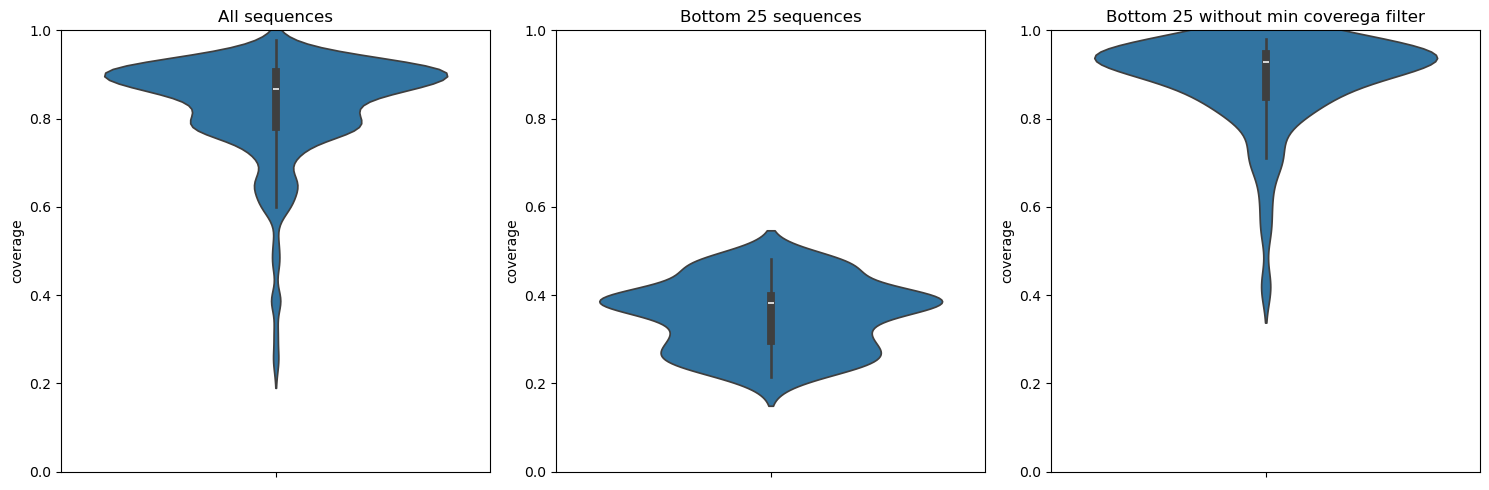

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

btm = 25
bottom_seqs = curated_df.sort_values('coverage')['sseqid'].unique()[0:btm]

# Define figure size directly here
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.violinplot(data=curated_df, y='coverage', ax=axs[0],cut=1)
axs[0].set_title("All sequences")
axs[0].set_ylim((0,1))

sns.violinplot(
    data=curated_df[curated_df['sseqid'].isin(bottom_seqs)],
    y='coverage',
    ax=axs[1])

axs[1].set_title(f"Bottom {btm} sequences")
axs[1].set_ylim((0,1))

# Find bottom coverage if sequences when unfiltering sequences
bottom_df = blast_df[blast_df['sseqid'].isin(bottom_seqs)]

# I apply the function 'total_coverage' to avoid map the same region multiple times
bottom_df = alignment_absolute_start_end(blast_df=bottom_df).sort_values(['sseqid', 'a.sstart', 'a.send'])
total_coverage_s = bottom_df.groupby('sseqid').apply(lambda x: total_coverage(x, use='subject'))
bottom_df['coverage'] = bottom_df['sseqid'].map(total_coverage_s)
#bottom_df

sns.violinplot(
    data=bottom_df,
    y='coverage',
    ax=axs[2])

axs[2].set_title(f"Bottom {btm} without min coverege filter")
axs[2].set_ylim((0,1))

plt.tight_layout()
plt.show()


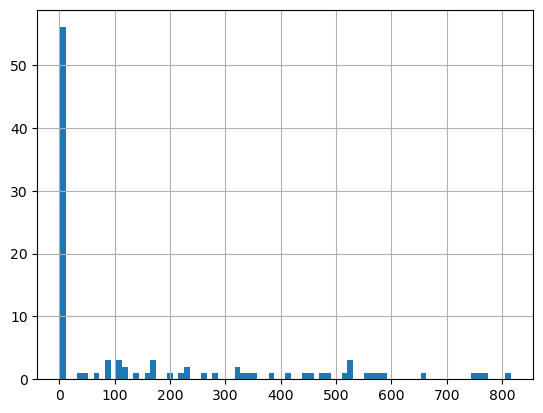

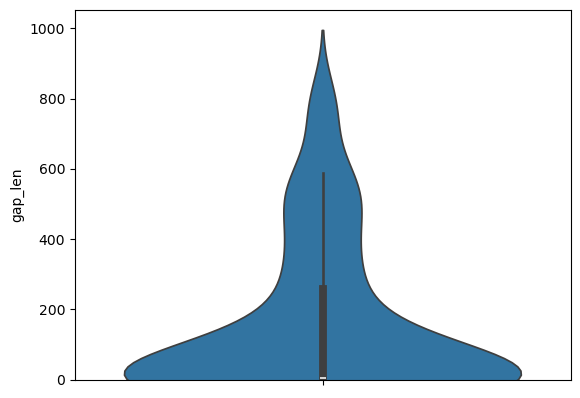

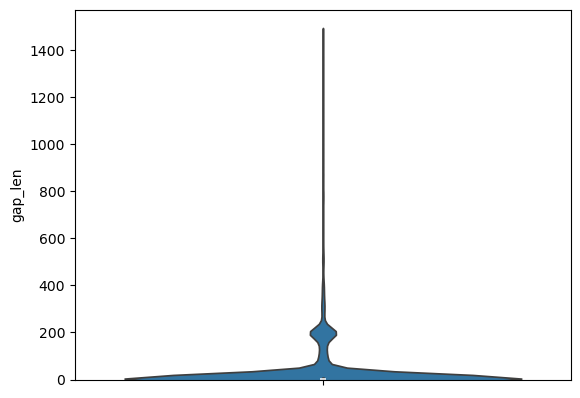

In [46]:
gaps_df[gaps_df['sseqid'].isin(bottom_seqs)]['gap_len'].hist(bins=80)
plt.show()

sns.violinplot(gaps_df[gaps_df['sseqid'].isin(bottom_seqs)]['gap_len'], cut=2)
plt.ylim(bottom=0)
plt.show()

sns.violinplot(gaps_df[~gaps_df['sseqid'].isin(bottom_seqs)]['gap_len'], cut=2)
plt.ylim(bottom=0)
plt.show()

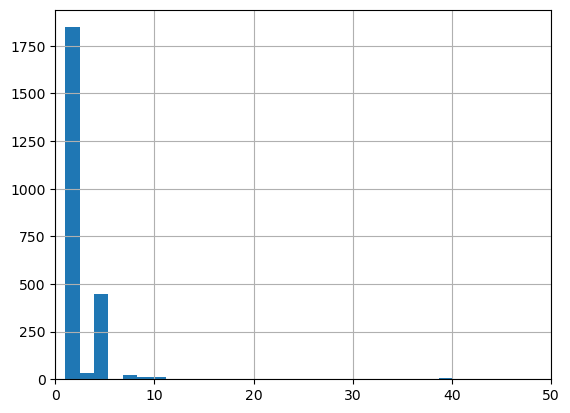

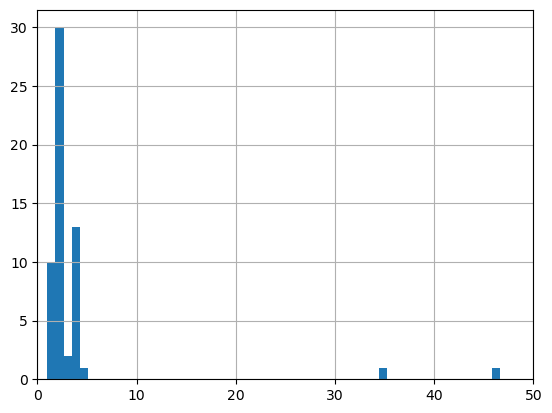

In [58]:
gaps_df[~gaps_df['sseqid'].isin(bottom_seqs)]['gap_len'].hist(bins=1000)
plt.xlim((0,50))
plt.show()

gaps_df[gaps_df['sseqid'].isin(bottom_seqs)]['gap_len'].hist(bins=1000)
plt.xlim((0,50))
plt.show()

In [ ]:
import pandas as pd
from utils.blast_utils import unmapped_subject_regions

# --- Paste your function here (unchanged) ---
# unmapped_subject_regions(...)

# --- 1) Build a toy BLAST table covering common edge cases ---
data = [
    # s1: len 100; hits [10,20], [30,40], and a minus-strand [80,60] -> normalized to [60,80]
    {"sseqid": "s1", "slen": 100, "a.sstart": 10, "a.send": 20, "pident": 95.0, "length": 11},
    {"sseqid": "s1", "slen": 100, "a.sstart": 30, "a.send": 40, "pident": 99.0, "length": 11},
    {"sseqid": "s1", "slen": 100, "a.sstart": 80, "a.send": 60, "pident": 92.0, "length": 21},

    # s2: len 50; adjacent hits [5,10] and [11,20] (tests merge_touching & n_mapped_intervals)
    {"sseqid": "s2", "slen": 50, "a.sstart": 5,  "a.send": 10, "pident": 88.0, "length": 6},
    {"sseqid": "s2", "slen": 50, "a.sstart": 11, "a.send": 20, "pident": 88.0, "length": 10},

    # s3: len 30; low-identity hit [3,8] that will be dropped when min_pident>=90
    {"sseqid": "s3", "slen": 30, "a.sstart": 3,  "a.send": 8,  "pident": 70.0, "length": 6},
]
blast_df = pd.DataFrame(data)

# --- 2) Run the function under different configurations ---
gaps_default   = unmapped_subject_regions(blast_df)  # no filters, merge_touching=True, pad=0
gaps_filtered  = unmapped_subject_regions(blast_df, min_pident=90)  # drops s2 and s3 hits
gaps_pad5      = unmapped_subject_regions(blast_df, pad=5)          # expands mapped regions by 5 bp
gaps_notouch   = unmapped_subject_regions(blast_df, merge_touching=False)

# --- 3) Assertions: expected complements ---

# Helper to pull (start,end) tuples per subject
def gaps_of(g, sid):
    return list(g[g.sseqid == sid][["gap_start","gap_end"]]
                .itertuples(index=False, name=None))

# A) Default behavior
assert gaps_of(gaps_default, "s1") == [(1,9), (21,29), (41,59), (81,100)]
# s2 adjacent hits merge into one covered span => two gaps
assert gaps_of(gaps_default, "s2") == [(1,4), (21,50)]
# s3 low-pident hit is still kept (no filter) => two gaps
assert gaps_of(gaps_default, "s3") == [(1,2), (9,30)]
# n_mapped_intervals counts merged mapped blocks
assert set(gaps_default[gaps_default.sseqid=="s2"]["n_mapped_intervals"]) == {1}

# B) With min_pident=90: only s1 remains (s2=88, s3=70 removed)
assert sorted(gaps_filtered.sseqid.unique()) == ["s1"]

# C) With padding=5 on s1: mapped spans dilate and merge
# [10,20]→[5,25], [30,40]→[25,45] (merge), [60,80]→[55,85] => gaps [1,4], [46,54], [86,100]
assert gaps_of(gaps_pad5, "s1") == [(1,4), (46,54), (86,100)]

# D) merge_touching=False: complement is the same for s2, but n_mapped_intervals changes (2)
assert gaps_of(gaps_notouch, "s2") == [(1,4), (21,50)]
assert set(gaps_notouch[gaps_notouch.sseqid=="s2"]["n_mapped_intervals"]) == {2}

print("All tests passed ✅")


All tests passed ✅


: 

: 

: 